In [16]:
import yfinance as yf
import gym
import gym_anytrading
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gym_anytrading.envs import StocksEnv
from finta import TA
import warnings
warnings.filterwarnings('ignore')

## Load CDR hist stock prices

In [5]:
ticker = yf.Ticker('CDR.WA')
data = ticker.history(period="14y")
data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2009-07-14 00:00:00+02:00,1.376212,1.385574,1.348126,1.376212,263489,0.0,0.0
2009-07-15 00:00:00+02:00,1.366850,1.423022,1.320040,1.348126,606998,0.0,0.0
2009-07-16 00:00:00+02:00,1.338764,1.366850,1.310678,1.338764,424938,0.0,0.0
2009-07-17 00:00:00+02:00,1.338764,1.357488,1.320040,1.338764,109601,0.0,0.0
2009-07-20 00:00:00+02:00,1.329402,1.394936,1.320040,1.376212,377450,0.0,0.0


## Add trading indicators

In [14]:
data['SMA'] = TA.SMA(data, 12)
data['RSI'] = TA.RSI(data)
data['OBV'] = TA.OBV(data)
data['SMM'] = TA.SMM(data)
data['VAMA'] = TA.VAMA(data)
data['STOCH'] = TA.STOCH(data)


data.fillna(0, inplace=True)
data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,SMA,RSI,OBV,SMM,VAMA,STOCH
Date,,,,,,,,,,,,,
2009-07-14 00:00:00+02:00,1.376212,1.385574,1.348126,1.376212,263489,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2009-07-15 00:00:00+02:00,1.366850,1.423022,1.320040,1.348126,606998,0.0,0.0,0.0,0.000000,-606998.0,0.0,0.0,0.0
2009-07-16 00:00:00+02:00,1.338764,1.366850,1.310678,1.338764,424938,0.0,0.0,0.0,0.000000,-1031936.0,0.0,0.0,0.0
2009-07-17 00:00:00+02:00,1.338764,1.357488,1.320040,1.338764,109601,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2009-07-20 00:00:00+02:00,1.329402,1.394936,1.320040,1.376212,377450,0.0,0.0,0.0,55.064462,-654486.0,0.0,0.0,0.0


In [21]:
def add_signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Low'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['Low', 'Volume','SMA', 'RSI', 'OBV','Dividends','SMM','VAMA','STOCH']].to_numpy()[start:end]
    return prices, signal_features

class CustomTradingEnv(StocksEnv):
    _process_data = add_signals

## Create trading env

In [18]:
total_number_of_obs = len(data) # total number of observations
window_size = 15 # number of observations avaiable for the agent in each episode
test_sample = 10 # number of days that we'll use for testing

env = gym.make('stocks-v0', # name of the env created by gym-anytrading
               df=data, # data
               window_size = window_size, 
               frame_bound = (window_size,total_number_of_obs-test_sample)) # training set


## Build Env and test it (agent makes random decision each day - to buy or to sell)

info {'total_reward': 297.02383148670197, 'total_profit': 3.82648473980639e-05, 'position': 1}


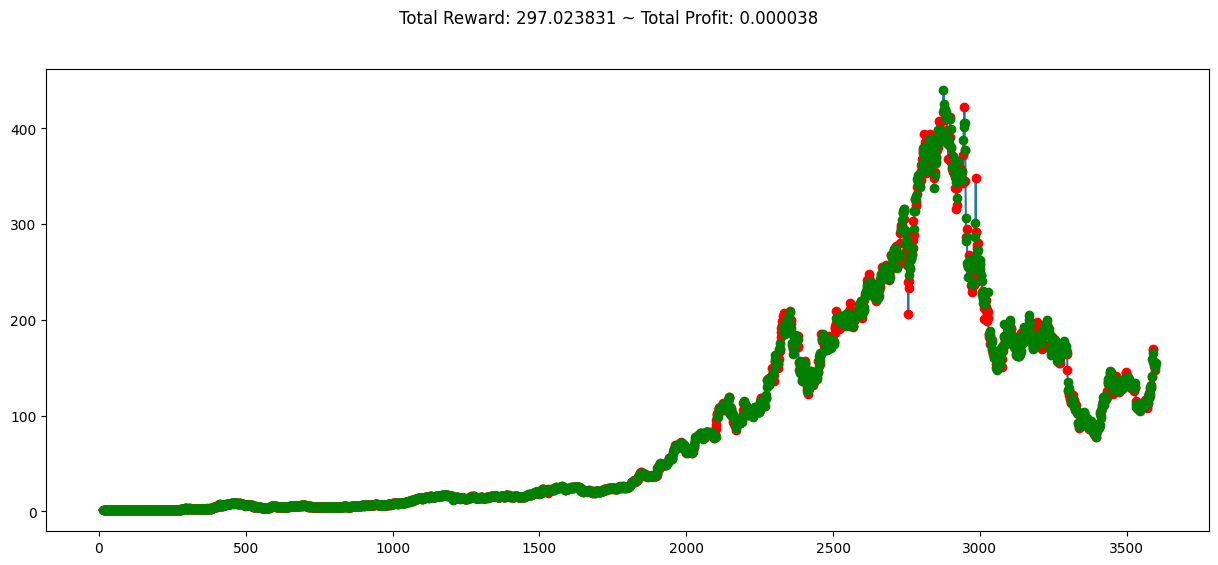

In [19]:
state = env.reset()
while True:
    action = env.action_space.sample()
    n_state, reward, done, info = env.step(action)
    if done:
        print("info",info)
        break

plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

## Use A2C agent with MLP lstm policy 

In [24]:
total_number_of_obs = len(data) # total number of observations
window_size = 15 # number of observations avaiable for the agent in each episode
test_sample = 10 # number of days that we'll use for testing

# env_maker = lambda: gym.make('stocks-v0', df=data, window_size = window_size, frame_bound = (window_size,total_number_of_obs-test_sample))
env = CustomTradingEnv(df=data, window_size = window_size, frame_bound = (window_size,total_number_of_obs-test_sample))

In [25]:
from stable_baselines3.common.callbacks import ProgressBarCallback, StopTrainingOnNoModelImprovement,CallbackList, EvalCallback

stop_train_callback = StopTrainingOnNoModelImprovement(max_no_improvement_evals=3, min_evals=5, verbose=0)
eval_callback = EvalCallback(env, eval_freq=1000, callback_after_eval=stop_train_callback, verbose=0)


In [52]:
agent = A2C('MlpPolicy',env,verbose=0)
agent.learn(total_timesteps=500000)


info {'total_reward': 0.0, 'total_profit': 0.9944654220342753, 'position': 1}


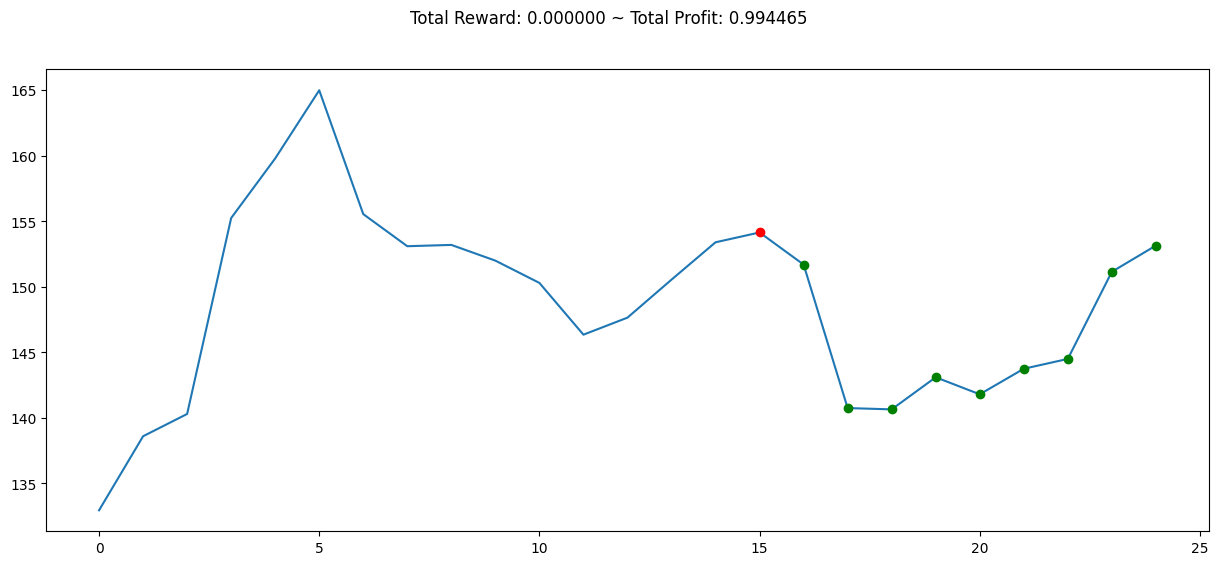

In [57]:

# env = gym.make('stocks-v0', df=data, frame_bound=(total_number_of_obs-test_sample,total_number_of_obs), window_size=15)
env = CustomTradingEnv(df=data, window_size = window_size, frame_bound = (total_number_of_obs-test_sample,total_number_of_obs))
obs = env.reset()
while True: 
    obs = obs[np.newaxis, ...]
    action, _states = agent.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break

plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

In [67]:
agent.save('A2C_agent')


In [68]:
import tensorflow as tf